## Group 33

- Alexandre Gonçalves (20240738)
- Bràulio Damba (20240007)
- João Henriques (20240499)
- Mariana Sousa (20240516)
- Victoria Goon (20240550)

### 1 - Mount and Imports

In [ ]:
# source: https://stackoverflow.com/questions/48376580/how-to-read-data-in-google-colab-from-my-google-drive
# This code is required to your Google Drive to the Colab environment

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# We used the following to extract the  original dataset + dataset obtained after outlier manual removal from a zip file saved in our drive
# The zip file is located in the path "/content/drive/MyDrive/dataset/data.zip"
# source: https://stackoverflow.com/questions/38320290/how-to-extract-zip-file-in-google-colab

import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/dataset/data.zip" , "r")

zip_ref.extractall("/content/dataset")

zip_ref.close()

In [4]:
import os
import pandas as pd
import shutil

In [ ]:
# Change the working directory to the correct folder. In the path below, the group member running the code saved the utils.py file and other required folders to run the code
os.chdir('/content/drive/MyDrive/dataset/project_structure')

print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/dataset/project_structure


In [6]:
from sklearn.model_selection import train_test_split


In [34]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from Library.utils import get_callbacks
from sklearn.metrics import classification_report

import tensorflow as tf

from keras.utils import image_dataset_from_directory
from keras.applications import VGG16, InceptionV3, ResNet50
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, F1Score, Precision, Recall


  # Image processing
from keras.utils import img_to_array, load_img
from keras.utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomTranslation, RandomRotation, RandomContrast
  # Model
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
#from tensorflow_addons.metrics import F1Score
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.models import Model
from keras.layers import (
    Input, Dense, Dropout, GlobalAveragePooling2D, Rescaling,
    RandomFlip, RandomRotation, RandomContrast, RandomTranslation
)
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.models import Sequential


#from Library.PreprocessingAugmentTemplate import Preprocessing_Augment_Template

In [8]:
os.chdir("/content")

In [9]:
# Load metadata
metadata_path = 'dataset//data//original//metadata.csv'
metadata = pd.read_csv(metadata_path)

# Verify data loaded correctly
metadata.head()

rare_species_id  eol_content_id  eol_page_id  \
0  75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1  28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2  00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3  29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4  94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   

    kingdom    phylum            family  \
0  animalia  mollusca         unionidae   
1  animalia  chordata       geoemydidae   
2  animalia  chordata  cryptobranchidae   
3  animalia  chordata          turdidae   
4  animalia  chordata         indriidae   

                                           file_path  
0  mollusca_unionidae/12853737_449393_eol-full-si...  
1  chordata_geoemydidae/20969394_793083_eol-full-...  
2  chordata_cryptobranchidae/28895411_319982_eol-...  
3  chordata_turdidae/29658536_45510188_eol-full-s...  
4  chordata_indriidae/21252576_7250886_eol-full-s...

### 2 - Dataset split

In [10]:
# Using stratufy to maintain the distribution of classes in the train, validation, and test sets
train_df, val_test_df = train_test_split(metadata, test_size=0.3, stratify=metadata['family'], random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, stratify=val_test_df['family'], random_state=42)

In [ ]:
# This function is used to move the images to implement the split defined above. After defining what images went to each set, we moved the images to the corresponding folders.


def move_images(df, folder_name, original_base_dir, target_base_dir):
    for _, row in df.iterrows():
        src_path = os.path.join(original_base_dir, row['file_path'])  # e.g., "arthropoda_apidae/image1.jpg"
        subfolder = os.path.dirname(row['file_path'])  # e.g., "arthropoda_apidae"
        dst_dir = os.path.join(target_base_dir, folder_name, subfolder)
        dst_path = os.path.join(dst_dir, os.path.basename(src_path))

        os.makedirs(dst_dir, exist_ok=True)

        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"Missing file: {src_path}")

In [12]:
# Change the working directory to the correct folder
os.chdir('/content/dataset/data/original')

print("Current working directory:", os.getcwd())

# Verify the contents of the folder
print("Contents of the 'original' directory:", os.listdir('/content/dataset/data/original'))

Current working directory: /content/dataset/data/original
Contents of the 'original' directory: ['source_images', '.ipynb_checkpoints', 'metadata.csv']


In [ ]:
# Set the base directory for the original images (inside source images folder). 
# Due to limited Google Drive storage for each group member, we couldn't permanently store in the drive the train, val, and test folders.
# As a result, we had to regenerate these datasets every time we ran the code, instead of saving them once for repeated use

original_base_dir = '/content/dataset/data/original/source_images'

# Set the base directory for the destination folders
#target_base_dir = 'data/original'

# Set the base directory for the destination folders
target_base_dir = '/content/dataset/data//original'

# Create directories for each split
os.makedirs(os.path.join(target_base_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(target_base_dir, 'validation'), exist_ok=True)
os.makedirs(os.path.join(target_base_dir, 'test'), exist_ok=True)

# Move images to their corresponding folders
move_images(train_df, 'train', original_base_dir, target_base_dir)
move_images(val_df, 'validation', original_base_dir, target_base_dir)
move_images(test_df, 'test', original_base_dir, target_base_dir)

### 3 - Training

In [14]:
n_classes = 202

In [ ]:
# Defining some of the parameters used in the model and to load the data
model_name = "VGG16"
epochs = 200
resolution = 224
batch_size = 64
n_classes = 202
augmentation = True

In [ ]:
# Load the image dataset in the train folder using a batch size of 64 and the resolution defined above
# we are also making sure that all images are in RGB format
# source: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

train_data = image_dataset_from_directory(
    Path("/content/dataset/data//original/train"),
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(resolution,resolution)
)

Found 8388 files belonging to 202 classes.


In [ ]:
# Load the image dataset in the validation data folder using a batch size of 64 and the resolution defined above
# we are also making sure that all images are in RGB format
# source: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory


val_data = image_dataset_from_directory(
    Path("/content/dataset/data//original/validation"),
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(resolution,resolution)
)

Found 1797 files belonging to 202 classes.


In [ ]:
# Load the image dataset in the test folder using a batch size of 64 and the resolution defined above
# we are also making sure that all images are in RGB format
# source: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

test_data = image_dataset_from_directory(
    Path("/content/dataset/data//original/test"),
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(resolution,resolution)
)

Found 1798 files belonging to 202 classes.


In [ ]:
# Defining the VGG16 model
# THe model design and compilation selected will be be explained in the report but the main structure was inspired by the following paper: https://repositorio.inesctec.pt/server/api/core/bitstreams/a9861ffd-05d8-4af0-b2ce-ec993863fbe2/content
# We decided to use VGG16 as the base architecture to define our data prepocessign strategy as it was the model used during the labs
# Additionally, this architecture is usefull as a pretrained feature extractor across various image classification tasks (source: https://arxiv.org/abs/1409.1556)


def build_vgg16_classifier(input_shape, num_classes, optimizer='adam', metrics=['accuracy']):
    """
    Build a VGG19-based image classification model with integrated data preprocessing and augmentation.

    Parameters:
        input_shape (tuple): Dimensions of input images (height, width, channels).
        num_classes (int): Total number of output classes.
        optimizer (str or keras.optimizers.Optimizer): Optimizer for training.
        metrics (list): List of evaluation metrics.

    Returns:
        keras.Model: Compiled image classification model.
    """

    # Define preprocessing + augmentation pipeline
    preprocess_block = Sequential(name="augmentation_pipeline")
    preprocess_block.add(Rescaling(1./255))
    preprocess_block.add(RandomFlip("horizontal_and_vertical"))
    preprocess_block.add(RandomRotation(0.15))
    preprocess_block.add(RandomContrast(0.2))
    preprocess_block.add(RandomTranslation(0.1, 0.1))

    # Define input layer
    input_tensor = Input(shape=input_shape, name="input_image")
    x = preprocess_block(input_tensor)

    # Load pre-trained VGG19 base (no top)
    vgg_base = VGG16(include_top=False, weights='imagenet', input_tensor=x)
    vgg_base.trainable = False  # Freeze feature extractor

    # Add classifier head
    x = GlobalAveragePooling2D()(vgg_base.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    output_tensor = Dense(num_classes, activation='softmax', name="output_probs")(x)

    # Compile final model
    model = Model(inputs=input_tensor, outputs=output_tensor, name="VGG16_Classifier")
    model.compile(
        optimizer=optimizer if isinstance(optimizer, str) else Adam(),
        loss='categorical_crossentropy',
        metrics=metrics
    )

    return model

In [ ]:
# Selection of metrics to evaluate the model performance
categorical_accuracy = CategoricalAccuracy(name="accuracy")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, f1_score, Precision(), Recall()]

# callbacks being used to monitor the model performance during training using the utils.py in the Library folder
callbacks = get_callbacks(
    base_dir="model_logs/" + model_name
)

In [ ]:
# Define the optimizer, loss function and the model to run
optimizer = Adam(learning_rate=0.001, name="optimizer")

model = build_vgg16_classifier(input_shape = (resolution,resolution,3), num_classes = n_classes, optimizer=optimizer, metrics=metrics)

loss = CategoricalCrossentropy(name="loss")

In [ ]:
# model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
# Obtain the model summary
# The model summary is useful to understand the model architecture
# source: https://stackoverflow.com/questions/36946671/keras-model-summary-result-understanding-the-of-parameters 
# source: https://keras.io/api/models/model/

model.summary()

Model: "VGG16_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation_pipeline           │ (None, 224, 224, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,79

 Total params: 14,963,722 (57.08 MB)

 Trainable params: 249,034 (972.79 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

In [ ]:
# Training the model using the fit method
# The fit method is used to train the model on the training data and validate it on the validation data. 
# source: https://keras.io/api/models/model_training_apis/
# source: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

result = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.0191 - f1_score: 0.0025 - loss: 5.2004 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 1: val_loss improved from inf to 4.94175, saving model to model_logs/VGG16/confident_model_checkpoint_20250419_1730.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 30s 181ms/step - accuracy: 0.0191 - f1_score: 0.0025 - loss: 5.1997 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.0568 - val_f1_score: 0.0026 - val_loss: 4.9418 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 9.5000e-04
Epoch 2/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.0495 - f1_score: 0.0046 - loss: 4.9419 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 2: val_loss improved from 4.94175 to 4.70493, saving model to model_logs/VGG16/confident_model_checkpoint_20250419_1730.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 23s 173ms/step - accuracy: 0.0496 - f1_score: 0.0046 - loss: 4.9415 - precision_1: 0.0000e+00 - recal

In [ ]:
# Using model.evaluate to evaluate the model performance on the test set
# The results differ from the classification report below as it uses the metrics defined in the model.compile method and can be less accurate if:
# 1) Custom metrics (like F1Score) use streaming/batch-wise approximations or 2) Small test set or imbalanced batches.
# source: https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate


test_results = model.evaluate(
    test_data,
    return_dict=True,
    verbose=1
)

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.2554 - f1_score: 0.1372 - loss: 3.2926 - precision_1: 0.8681 - recall_1: 0.0893


In [ ]:
# Classification report to evaluate the model performance with the performance per class and the overall performance
# Tends to give more precise results since it calculates exact metrics on the entire dataset at once (global view) using our manually predicted labels
# source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

y_true = []
y_pred = []
class_names = train_data.class_names

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Results

Test Loss: 3.296318531036377
Test Accuracy: 0.25973305106163025


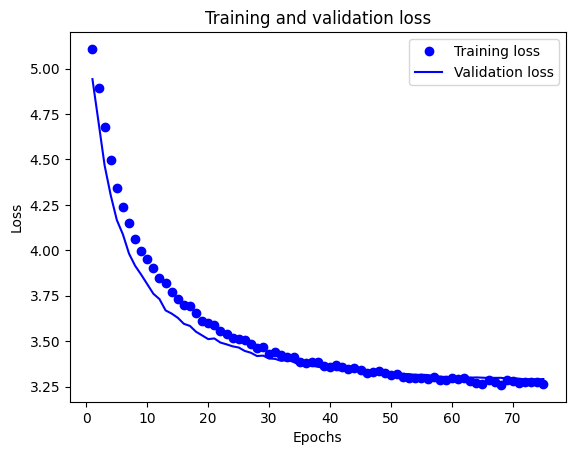

In [ ]:
# Plot that compares the training and validation loss across training epochs
# The plot is useful to understand the model performance and if it is overfitting or underfitting


# Print evaluation results
print("Test Loss:", test_results['loss'])
print("Test Accuracy:", test_results['accuracy'])

# Step 3: Plot the loss
loss = result.history['loss']
val_loss = result.history['val_loss']
epochs_range = range(1, len(loss) + 1)

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()